In [1]:
%%bash
rm -r Data
mkdir Data
cp ../ubuntu/ZZ17001a/mm10/barcodes.tsv Data/
cp ../ubuntu/ZZ17001a/mm10/genes.tsv Data/
cp ../ubuntu/ZZ17001a/mm10/matrix.mtx Data/

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.io
import scipy.stats as stats
from statsmodels.robust.scale import mad
pd.core.config.option_context('mode.use_inf_as_null',True)
import seaborn as sns
import os 
import sys
import csv
import shlex
import subprocess

sys.setrecursionlimit(10000)

from plotly.graph_objs import Scatter3d, Data, Marker,Layout, Figure, Scene, XAxis, YAxis, ZAxis
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

matplotlib.rcParams['axes.edgecolor']='k'
matplotlib.rcParams['axes.linewidth']=3
matplotlib.rcParams['axes.spines.top']='off'
matplotlib.rcParams['axes.spines.right']='off'
matplotlib.rcParams['axes.facecolor']='white'

In [2]:
def read10X(path):
    mat = scipy.io.mmread(os.path.join(path,"matrix.mtx"))
 
    genes_path =os.path.join(path,"genes.tsv")
    gene_ids = [row[0] for row in csv.reader(open(genes_path), delimiter="\t")]
    gene_names = [row[1] for row in csv.reader(open(genes_path), delimiter="\t")]

    barcodes_path = os.path.join(path,"barcodes.tsv")
    barcodes = [row[0] for row in csv.reader(open(barcodes_path), delimiter="\t")]
    
    featureData=pd.DataFrame(data=gene_names, index=gene_ids, columns=['Associated.Gene.Name'])
    
    counts=pd.DataFrame(index=gene_ids,columns=barcodes,data=mat.todense())
    
    return counts, featureData

def filterCells(counts):
    umi_counts=counts.sum()
    cells1000=umi_counts[umi_counts>500].index
    
    return cells1000

def filterGenes(counts):
    filteredGenes=counts.index[(counts >= 2).sum(1) >=2]
    return filteredGenes

def plotQC(counts):
    genesdetected=(counts>=1.).sum()
    umi_counts=counts.sum()
    fig,(ax,ax1)=plt.subplots(1,2,figsize=(10, 5))

    genesdetected.plot(kind='hist',bins=np.arange(0,5000,100),lw=0,ax=ax)
    ax.grid('off')
    ax.patch.set_facecolor('white')
    ax.axvline(x=np.median(genesdetected),ls='--',lw=2,c='k')
    ax.set_xlabel('Genes',fontsize=13)
    ax.set_ylabel('Cells',fontsize=13)

    umi_counts.plot(kind='hist',bins=np.arange(0,10000,500),lw=0,ax=ax1,color=sns.color_palette()[1])
    ax1.grid('off')
    ax1.patch.set_facecolor('white')
    ax1.axvline(x=np.median(umi_counts),ls='--',lw=2,c='k')
    ax1.set_xlabel('Transcripts - UMI',fontsize=13)
    ax1.set_ylabel('Cells',fontsize=13)

def normalize(counts):
    cells1000=filterCells(counts)
    filteredGenes=filterGenes(counts)
    umi_counts=counts.sum()
    
    cpt=counts*np.median(umi_counts)/umi_counts
    cpt=cpt.loc[filteredGenes,cells1000]
    cpt=(cpt+1).apply(np.log)
    
    return cpt

def overdispersion(cpt,nGenes):
    
    meanExpression=np.log(np.mean(np.exp(cpt)-1,1)+1)
    dispersion=np.log(np.var(np.exp(cpt)-1,1)/np.mean(np.exp(cpt)-1,1))
    bins = np.linspace(min(meanExpression),max(meanExpression),20)
    pos = np.digitize(meanExpression, bins)
    overDispersion=[]

    for index,gene in enumerate(meanExpression.index):
        medianBin=dispersion[pos==pos[index]].median()
        madBin=mad(dispersion[pos==pos[index]])
        normalizedDispersion=abs(dispersion.ix[gene]-medianBin)/madBin
        overDispersion.append([ gene, normalizedDispersion ])

    overDispersion=pd.DataFrame(overDispersion)
    overDispersion.set_index(0,inplace=True)
    top1000=overDispersion.sort_values(1,ascending=False)[:nGenes].index
    
    return top1000
    
def variance(cpt,nGenes):
    variance=cpt.var(1)
    top1000=variance.sort_values(inplace=True,ascending=False)[:nGenes].index
    
    return top1000
    
def runTSNE(cpt,genes):
    np.savetxt('Data/filtered.tsv', cpt.loc[top1000].T.values, delimiter='\t')
    cmd='/Users/mby/Downloads/bhtsne-master/bhtsne.py -d 3 -i Data/filtered.tsv --no_pca -r 1024 -o Data/out.tsv'
    cmd=shlex.split(cmd)    
    proc=subprocess.Popen(cmd,stdout=subprocess.PIPE,stderr=subprocess.PIPE)
    stdout, stderr=proc.communicate()
    tsne=np.loadtxt('Data/out.tsv')
    tsneData=pd.DataFrame(tsne,index=cpt.columns, columns=['V1','V2','V3'])
    return tsneData

def PCA(cpt,genes):
    from sklearn.decomposition import PCA as sklearnPCA
    sklearn_pca = sklearnPCA(n_components=50)
    Y_sklearn = sklearn_pca.fit_transform(cpt.ix[top1000].T)
    
    pcaData=pd.DataFrame(Y_sklearn,index=cpt.columns)
    
    eig_vals=sklearn_pca.explained_variance_
    tot = sum(eig_vals)
    var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
    cum_var_exp = np.cumsum(var_exp)
    
    return pcaData,cum_var_exp

def getEnsid(featureData,gene):
    return featureData[featureData['Associated.Gene.Name']==gene].index

def plotTSNE(cpt,tsnedata,gene,featureData,dim1,dim2):
    fig,ax=plt.subplots(1)
    ax.scatter(tsnedata[dim1],tsnedata[dim2],c=cpt.loc[getEnsid(featureData,gene),],s=10, 
               linewidths=1, cmap=plt.cm.Greens,vmax=2,vmin=0.1)
    ax.set_title(gene)
    
    #return fig

def dbscan(tsnedata,eps,minCells):
    from sklearn.cluster import DBSCAN
    db = DBSCAN(eps=eps, min_samples=minCells).fit(tsnedata.values)
    tsnedata['dbCluster'] = db.labels_+1
    
    return tsnedata

def plotTSNEClusters(tsnedata,dim1,dim2):
    colors=['#a6cee3','#1f78b4','#b2df8a',
        '#33a02c','#fb9a99','#e31a1c',
        '#fdbf6f','#ff7f00','#cab2d6',
        '#6a3d9a','#ffff99','#b15928',
       '#000000','#bdbdbd','#ffff99']

    k2=sns.lmplot(dim1, dim2, data=tsnedata, hue='dbCluster', fit_reg=False,palette=colors,scatter_kws={"s": 5})
    k2.ax.grid('off')
    k2.ax.patch.set_facecolor('white')
    #k2.savefig('../Figures/TSNE-KM.pdf',format='pdf',dpi=300)

def mkRds(cpt,featureData,tsnedata):
    
    cpt.to_csv('Data/Expression-G.csv')
    featureData['Chromosome.Name']=1
    featureData.to_csv('Data/MM10_10X-FeatureData.csv')
    tsnedata.to_csv('Data/TSNEData-Dbscan.csv')
    
    rscript='''
    rm(list=ls())

    setwd('%s')

    log2cpm<-read.csv('%s',row.names=1,stringsAsFactors = F, as.is=T, check.names=F)
    featuredata<-read.csv('%s',row.names=1,stringsAsFactors = F, as.is=T,sep=',',check.names=F)
    tsne.data<-read.csv('%s',row.names=1,stringsAsFactors = F,as.is=T,check.names=F)

    save(log2cpm,featuredata,tsne.data,file='%s')

    '''%(os.getcwd(),'Data/Expression-G.csv','Data/MM10_10X-FeatureData.csv',
         'Data/TSNEData-Dbscan.csv','Data/Data.Rds')
    
    with open('Data/setupRds.R','w') as fout:
        fout.writelines(rscript)
        
    cmd='R --no-save -f Data/setupRds.R'
    os.system(cmd)

def tsne3d(tsnedata):
    walkers=[]
    colors=['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6',
            '#6a3d9a','#ffff99','#b15928','#000000','#bdbdbd','#ffff99']
    colors=colors*3

    for ii in range(0,44,1):
        tsne_subset=tsnedata[tsnedata['dbCluster']==ii]

        cellnames=tsne_subset.index
        a=tsne_subset['V1'].values
        b=tsne_subset['V2'].values
        c=tsne_subset['V3'].values

        trace = Scatter3d(
            x=a,
            y=b,
            z=c,
            text=['CellName: %s' %(i) for i in cellnames],
            mode='markers',
            name=ii,
            marker=dict(
            color=colors[ii],
            size=3,
            symbol='circle',
            line=dict(
                color=colors[ii],
                width=0
            )
        ))
        walkers.append(trace)

    data = Data(walkers)

    layout = Layout(
        title='BS16001-TE1',
        hovermode='closest',

        xaxis=dict(
            title='TSNE-1',
            ticklen=0,
            showline=True,
            zeroline=True
        ),
        yaxis=dict(
            title='TSNE-2',
            ticklen=5,
        ),    
        scene=Scene(
            xaxis=XAxis(title='TSNE-1',showgrid=True,zeroline=True,showticklabels=True),
            yaxis=YAxis(title='TSNE-2',showgrid=True,zeroline=True,showticklabels=True),
            zaxis=ZAxis(title='TSNE-3',showgrid=True,zeroline=True,showticklabels=True)
            )
        )


    fig = Figure(data=data, layout=layout)
    iplot(fig)
    
def findMarkers(cpt,cells1,cells2,genes):
    aucScores=[]
    from sklearn import metrics
    for gene in genes:
        y=[1]*len(cells2)+[2]*len(cells1)
        pred = np.concatenate((cpt.loc[gene,cells2],cpt.loc[gene,cells1]))
        fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=2)
        aucScores.append(metrics.auc(fpr, tpr))
    return pd.DataFrame(aucScores,index=genes,columns=['Score'])

def expMean(x):
    return(np.log(np.mean(np.exp(x)-1)+1))

def markerHeatmap(cpt,genes,tsnedata_dbscan,featureData):
    hdata=cpt.loc[genes,].dropna()
    colorMap=dict(zip(range(1,8,1),sns.color_palette('Set1',9)))

    hetmap=sns.clustermap(hdata,z_score=0,yticklabels=False,vmin=-3,vmax=3,\
                          xticklabels=featureData.loc[genes,'Associated.Gene.Name']
                          ,row_cluster=True,col_cluster=True
                          ,col_colors=colorMap,metric='correlation'
                         )
    b=plt.setp(hetmap.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)



### Read Input data

In [ ]:
counts, featuredata=read10X('Data/')

### Shape of dataset: Genes, Cells

In [ ]:
counts.shape

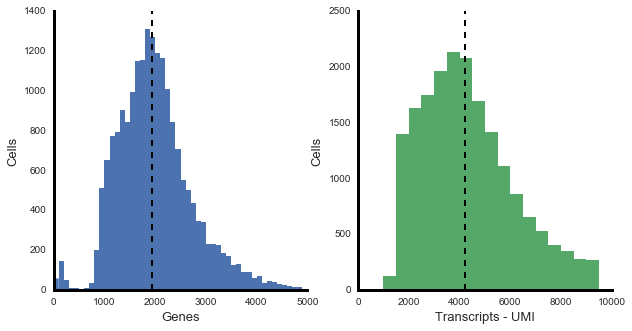

In [5]:
plotQC(counts)

### Normalize data
Since number of genes and transcipts detected is directly dependent on read depth, library size normalization is essential. This function will normalize gene expression based on total transcripts detected in each cell, multiply with a constant and log transform.

In [6]:
cpt=normalize(counts)

### Feature Selection
One of the most important steps in single cell RNA seq processing, is selecting genes that describe most of the biological variance. However, this is confounded by the high levels of technical noise associated with single cell RNA-seq data. 

***This jupyter notebook contains 2 functions to enable feature selection:***
1. variance - select the top variable genes in the dataset
2. overdispersion - select the top variable genes in the dataset corrected for technical variance

In [7]:
top1000=overdispersion(cpt,1000)

/Users/mby/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:68: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix

/Users/mby/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:68: RuntimeWarning:

invalid value encountered in double_scalars



### Dimensionality reduction 
After gene selection, the high dimensionality of single cell RNA-seq data is commnly reduced to cluster similar cells together. 
***This jupyter notebook contains 2 functions for dimensionality reduction:***
1. PCA 
2. tSNE - for the purposes of the demonstration, we will use tSNE and reduce data to 3 dimensions

In [8]:
tsnedata=runTSNE(cpt,top1000)

KeyboardInterrupt: 

In [ ]:
tsnedata=pd.read_csv('')

### Visualization 
Visualization is an important part of an single cell experiment. Exploring data with genes of interest helps validate clustering as wells begins the process of identifying the cell type of each cluster

Lets take a look at our dimensionality reduction by plotting cells.

In [ ]:
plt.scatter(tsnedata['V2'],tsnedata['V3'],s=5)

### Visualization 
Visualization is an important part of an single cell experiment. Exploring data with genes of interest helps validate clustering as wells begins the process of identifying the cell type of each cluster

Lets take a look at our dimensionality reduction by plotting cells, but this time color each cell by the expression of particular gene. Pick from Emcn, Olig1, Olig2, Pdgra, Fyn, Aqp4,Mog,Slc32a1,Slc17a6,Cx3cr1.

In [ ]:
plotTSNE(cpt,tsnedata,'Snap25',featuredata,'V2','V3')

### Cluster identification 
After dimensionality reduction, clusters are identified using a variety of approaches. We will use a simple algorithm called DBSCAN to identify clusters

***This jupyter notebook contains 1 functions for dimensionality reduction:***
1. DBSCAN 

In [ ]:
tsnedata_dbscan=dbscan(tsnedata,3.2,20)

### Visualization 

Lets take a look at our dimensionality reduction by plotting cells, but this time color each cell by the cluster assignment as determined by DBSCAN

In [ ]:
plotTSNEClusters(tsnedata_dbscan,'V2','V3')

### Visualization 

Lets take a look at our dimensionality reduction by plotting cells, but this time color each cell by the cluster assignment as determined by DBSCAN. Remember that our data was reduced to 3 dimensions. So, lets plot all 3 dimensions

In [ ]:
walkers=[]
colors=['#a6cee3','#1f78b4','#b2df8a',
        '#33a02c','#fb9a99','#e31a1c',
        '#fdbf6f','#ff7f00','#cab2d6',
        '#6a3d9a','#ffff99','#b15928',
       '#000000','#bdbdbd','#ffff99']

for ii in range(0,44,1):
    tsne_subset=tsne[tsne['dbCluster']==ii]

    cellnames=tsne_subset.index
    a=tsne_subset['V1'].values
    b=tsne_subset['V2'].values
    c=tsne_subset['V3'].values

    trace = Scatter3d(
        x=a,
        y=b,
        z=c,
        text=['CellName: %s' %(i) for i in cellnames],
        mode='markers',
        name=ii,
        marker=dict(
        color=colors[ii],
        size=3,
        symbol='circle',
        line=dict(
            color=colors[ii],
            width=0
        )
    ))
    walkers.append(trace)

data = Data(walkers)

layout = Layout(
    title='BS16001-TE1',
    hovermode='closest',
 
    xaxis=dict(
        title='TSNE-1',
        ticklen=0,
        showline=True,
        zeroline=True
    ),
    yaxis=dict(
        title='TSNE-2',
        ticklen=5,
    ),    
    scene=Scene(
        xaxis=XAxis(title='TSNE-1',showgrid=True,zeroline=True,showticklabels=True),
        yaxis=YAxis(title='TSNE-2',showgrid=True,zeroline=True,showticklabels=True),
        zaxis=ZAxis(title='TSNE-3',showgrid=True,zeroline=True,showticklabels=True)
        )
    )

        
fig = Figure(data=data, layout=layout)
py.iplot(fig, filename='BS16001-TE1-KMEANS.html')

In [ ]:
tsne3d(tsnedata_dbscan)

### Marker Identification
Identifying genes that differentiate each of these cell populations is an important aspect of single cell RNA-seq data. There are many different methods to do this type of analysis. Given the size of the dataset ome of these are compute heavy. For the sake of brevity, we will use AUROC classification of differentially expressed genes. 

In [ ]:
aurocScoresAll=pd.DataFrame()
for cluster in range(1,8,1):

    cells1=tsnedata_dbscan[tsnedata_dbscan['dbCluster']==cluster].index
    cells2=tsnedata_dbscan.index.difference(cells1)

    data1=cpt.loc[cpt.index,cells1].apply(expMean,1)
    data2=cpt.loc[cpt.index,cells2].apply(expMean,1)
    totaldiff=(data1-data2)
    genes=totaldiff[totaldiff>1.].index

    aurocScores=findMarkers(cpt,
                  cells1,
                  cells2,
                  genes
                 )
    aurocScores['Associated.Gene.Name']=featuredata['Associated.Gene.Name']
    aurocScores['dbCluster']=cluster
    aurocScoresAll=aurocScoresAll.append(aurocScores)

### Visualization 

Let's make a heatmap of all markergenes

In [ ]:
markerHeatmap(cpt,aurocScoresAll.index,tsnedata_dbscan,featuredata)

### Make .Rds file for CellView 

And finally, let's summarize this analysis into an .Rds file that we can share with others

In [37]:
mkRds(cpt,featuredata,tsnedata_dbscan)